In [20]:
from forced_convection_dft.forward_models import ForwardModelDft, ForwardModelThermocouple
from forced_convection_dft.find_incident_heat_flux import HeatFluxFinder
from dft_inverse_code import dft_models, heat_transfer_coefficients
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation info

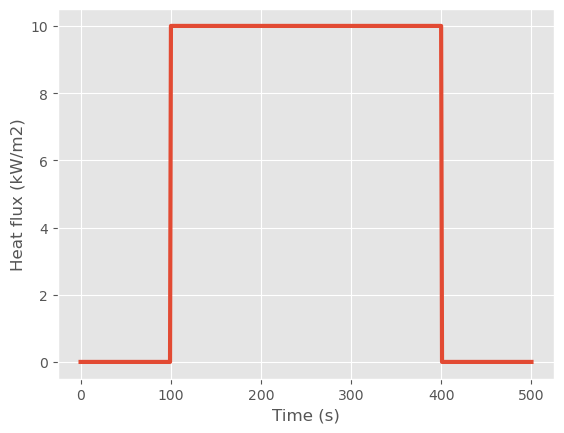

In [11]:
n_points = 500
time_vector = np.linspace(0, 500, n_points)
velocity = np.ones(n_points) * 2
temp_init = 21 + 273
temp_surr = 21 + 273
temp_amb = 200 + 273
q_inc = np.ones_like(time_vector) * 10e3
q_inc[time_vector < 100] = 0
q_inc[time_vector > 400] = 0

plt.plot(time_vector, q_inc / 1e3, lw=3)
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m2)');

# Properties

In [12]:
diameter_tc = 1.4e-3
density_tc = 8665
heat_capacity_tc = 485.6 
emissivity_tc = 0.8
alpha_tc = 0.8
dft_thickness =  0.0016
insulation_thickness = .019
plate_side_length = .0762

# Run forward model

In [13]:
forward_dft = ForwardModelDft(n_nodes=10, time=time_vector, insul_thickness=insulation_thickness, plate_thickness=dft_thickness, q_inc=q_inc,
                 characteristic_velocity=velocity, temp_init=temp_init, temp_amb=temp_amb, temp_surr=temp_surr, dft_plate_length=plate_side_length)
temp_f, temp_b, temp_ins, h_f, h_b = forward_dft.run()
forward_tc = ForwardModelThermocouple(time_vector, q_inc, velocity, temp_init,
                 temp_amb, temp_surr, emissivity_tc, alpha_tc, diameter_tc, heat_capacity_tc,
                 density_tc)
temp_tc = forward_tc.run()

100%|██████████| 499/499 [00:00<00:00, 14763.26it/s]


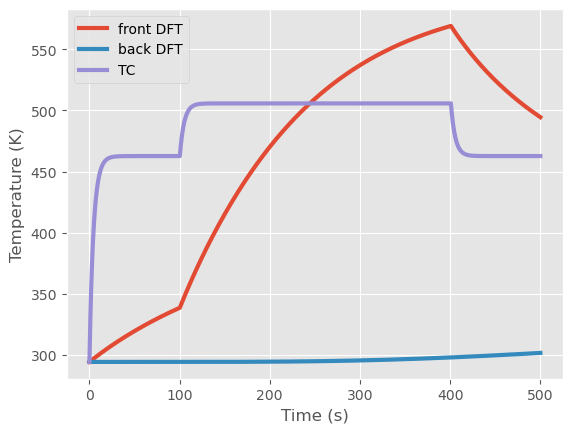

In [14]:
plt.plot(time_vector, temp_f, lw=3, label='front DFT')
plt.plot(time_vector, temp_b, lw=3, label='back DFT')
plt.plot(time_vector, temp_tc, lw=3, label='TC')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)');

# Recover heat flux

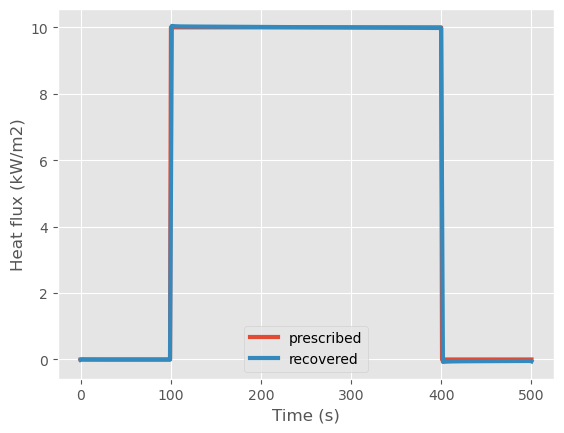

In [15]:
hf_finder = HeatFluxFinder(temp_f, temp_b, temp_tc, temp_amb,
                   temp_init, temp_surr, time_vector, diameter_tc,
                   alpha_tc, alpha_tc, heat_capacity_tc, density_tc, 
                           constant_velocity=True,  
                           plate_side_length=plate_side_length)
plt.plot(time_vector, q_inc / 1e3, lw=3, label='prescribed')
plt.plot(time_vector, hf_finder.find_q_inc(), lw=3, label='recovered')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m2)');

In [16]:
hf_finder.velocity

array([2.01239328])

# Compare with just using natural convection heat transfer coefficient

In [17]:
h_f_nat = heat_transfer_coefficients.natural_convection(
            (temp_f + temp_amb).reshape(-1, 1) / 2, Kelvin=True,
           T_infty=temp_amb).custom(0.65, 0.25).flatten()

In [18]:
q_inc_plate = dft_models.one_dim_conduction(T_f=temp_f, T_b=temp_b, time=time_vector, h_f=h_f_nat, h_b=h_b, model='one_d_conduction', Kelvin=True, T_inf=temp_amb, T_sur=temp_surr).q_inc

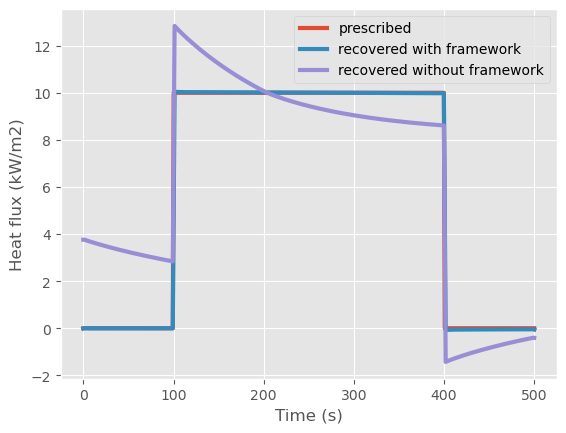

In [19]:
plt.plot(time_vector, q_inc / 1e3, lw=3, label='prescribed')
plt.plot(time_vector, hf_finder.find_q_inc(), lw=3, label='recovered with framework')
plt.plot(time_vector, q_inc_plate, lw=3, label='recovered without framework')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heat flux (kW/m2)');